In [1]:
import pymysql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dbeaver_connect import create_df_pymysql

In [2]:
# Define connection details in a format that is expected by dbeaver_connect functions:

connection_details = {"host": 'eufmd-database-1.cqodkl4vazie.eu-north-1.rds.amazonaws.com',
                      "user": 'root',
                      "password": 'YOUR_PASSWORD',
                      "db": 'db_tompilot',
                      "port": 3306
}

In [3]:
# Define the SQL query that is expected by the dbeaver_connect functions:

df_query_dict = {"competencies": "SELECT * FROM db_tompilot.competencies",
                 "countries": "SELECT * FROM db_tompilot.countries",
                 "course_categories": "SELECT * FROM db_tompilot.course_categories",
                 "courses": "SELECT * FROM db_tompilot.courses",
                 "position_competency_by_country": "SELECT * FROM db_tompilot.position_competency_by_country",
                 "positions": "SELECT * FROM db_tompilot.positions",
                 "regions_geolocation": "SELECT * FROM db_tompilot.regions_geolocation",
                 "roles": "SELECT * FROM db_tompilot.roles",
                 "self_assessment": "SELECT * FROM db_tompilot.self_assessment",
                 "tom_enrolments": "SELECT * FROM db_tompilot.tom_enrolments",
                 "trainings": "SELECT * FROM db_tompilot.trainings",
                 "user_course_enrolled": "SELECT * FROM db_tompilot.user_course_enrolled",
                 "user_course_enrolled_moodle": "SELECT * FROM db_tompilot.user_course_enrolled_moodle",
                 "users": "SELECT * FROM db_tompilot.users",  
}

In [4]:
# Convert SQL queries to dataframes:

for item in df_query_dict:
    query = df_query_dict[item]
    df_query_dict[item] = create_df_pymysql(connection_details, query)

/Users/meganguidry/Documents/TOM-Recommender-System/dbeaver_connect.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
for item in df_query_dict:
    print(item, df_query_dict[item].shape)

competencies (13, 2)
countries (12, 8)
course_categories (34, 3)
courses (428, 8)
position_competency_by_country (179, 5)
positions (23, 4)
regions_geolocation (129, 7)
roles (3, 3)
self_assessment (111, 4)
tom_enrolments (1988, 18)
trainings (142, 12)
user_course_enrolled (700, 7)
user_course_enrolled_moodle (234, 10)
users (223, 15)


In [6]:
# what data do we have in tom_enrolments?
tom_enrolments_df = df_query_dict["tom_enrolments"]

tom_enrolments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1988 non-null   int64  
 1   full_name         1988 non-null   object 
 2   email             1988 non-null   object 
 3   course_fullname   1988 non-null   object 
 4   course_shortname  1988 non-null   object 
 5   course_category   1988 non-null   object 
 6   city              1988 non-null   object 
 7   country           1988 non-null   object 
 8   institution       1988 non-null   object 
 9   role              1988 non-null   object 
 10  completed         1988 non-null   object 
 11  time_enrolled     1988 non-null   object 
 12  time_completed    1904 non-null   object 
 13  progress          1988 non-null   float64
 14  status            1988 non-null   object 
 15  course_id         1919 non-null   float64
 16  moodle_category   1988 non-null   object 


## Initial questions about tom_enrolments
#### What data is missing or incomplete?
    - 69 values of course_id are Nan
    - 1010 "roles" are missing. These show up in the database as blank strings ('').
    - City, institution, and moodle_category also have many instances of blank strings.
#### What data do we want from the tom_enrolment table?
    - id
    - full name
    - course_fullname
    - course_shortname
    - course_category
    - course_id
    - country
    - role
    - progress (if 100 then we know it is complete)
    - time_enrolled
    - time_completed
#### What is the distribution of comple vs. incomplete courses?
    - 1365 are 50% complete
    - 572 are fully complete
    - 35 have not yet been progressed
    - 8 are somewhere between not started and 50% complete
    - 8 are somewhere between 50% complete and 100% complete 

#### <font color='red'> How will we map the courses in tom_enrolments to the courses in the brick mapping sheet? </font>
    - Tom_enrolmets has course_fullname, course_shortname, and course_category
    - The brick mapping sheet has course
    - Does "course" from the brick mapping and "course_fullname" match?

    example: In the brick mapping sheet we have "FMD/RVF/SPGP/LSD Emergency preparedness course". In Tom_enrolments we have "FMD Emergency Preparation Course (EN13)". These types of inconsistencies will need to be adressed.
    
#### What do enrolments over time look like? Are enrolments stable, increasing, decreasing, or showing other trends?
#### Where are the learners from? (country)
    - In the tom_enrolments data we can see that leanrers are from the following countries: Armenia, Spain, Switzerland, Tunisia, Turkey. No other countries are currently present in the tom_enrolments data.
    
#### How long does it take for learners to complete courses?
    - to be determined. in order to figure this out we need to calculate a duration feature that subtracts the start datetime from the end datetime.
    
#### What are the most popular courses?

## Initial questions about the competencies mapping (brick skills present in each course)
#### Why are there only 19 courses in the mapping sheet?

### What data is missing or incomplete?
At a glance it looks like there are not many missing values in the dataframe. However, the Nan values have been replaced with empty strings. I want to see how many instances of "" can be found in the tom_enrolments dataframe.

In [7]:
# The isna() methos shows us that there are not many Nan values in the dataframe aside from in the course_id column.
# (A Nan value in the time completed column means the course has not been completed)

tom_enrolments_df.isna().sum()

id                   0
full_name            0
email                0
course_fullname      0
course_shortname     0
course_category      0
city                 0
country              0
institution          0
role                 0
completed            0
time_enrolled        0
time_completed      84
progress             0
status               0
course_id           69
moodle_category      0
new_id               0
dtype: int64

In [8]:
tom_enrolments_df.head(20)

,id,full_name,email,course_fullname,course_shortname,course_category,city,country,institution,role,completed,time_enrolled,time_completed,progress,status,course_id,moodle_category,new_id
0,6379,Jon Simonyan,jsimmk19@mail.ru,Open Session Online 2014,Open Session Online 2014,NU,Erevan,Armenia,,,No,2020-07-10 00:00:00,None,50.0,Open,45.0,Resources / Open Session,179
1,6392,Mariam Militosyan,militosyan_96@mail.ru,Обучающий Онлайн Курс по Изучению Ящура на рус...,FITC_RU4,FMD Investigation Training Course,,Armenia,,,Yes,2020-09-17 00:00:00,2020-10-21 00:00:00,100.0,Completed,244.0,FMD Investigation Training Course,180
2,6393,Mariam Militosyan,militosyan_96@mail.ru,Knowledge Bank,Knowledge Bank,NU,,Armenia,,,No,2020-09-28 00:00:00,None,50.0,Open,3.0,Resources,181
3,6394,Irma Artushyan,irma.artushyan95@mail.ru,Обучающий Онлайн Курс по Изучению Ящура на рус...,FITC_RU4,FMD Investigation Training Course,,Armenia,,,Yes,2020-09-17 00:00:00,2020-10-21 00:00:00,100.0,Completed,244.0,FMD Investigation Training Course,183
4,6395,Irma Artushyan,irma.artushyan95@mail.ru,Open Session Online 2014,Open Session Online 2014,NU,,Armenia,,,No,2020-05-10 00:00:00,None,50.0,Open,45.0,Resources / Open Session,185
5,6441,Ilhan Genc,ilhan.genc@tarimorman.gov.tr,Altıncı Türkçe Çevrimiçi Şap Hastalığı Araştır...,FITC_TR6,FMD Investigation Training Course,ERZURUM,Armenia,,Central level government veterinarian,Yes,2022-11-14 00:00:00,2022-12-13 00:00:00,100.0,Completed,375.0,FMD Investigation Training Course,186
6,6442,Ilhan Genc,ilhan.genc@tarimorman.gov.tr,Knowledge Bank,Knowledge Bank,NU,ERZURUM,Armenia,,Central level government veterinarian,No,2022-11-25 00:00:00,None,50.0,Open,3.0,Resources,189
7,6459,Pascal Truong,pascal.truong@bluewin.ch,FMD Emergency Preparation Course (EN13),FEPC_EN13,FMD Emergency Preparation Course,,Switzerland,,Regional level/field veterinarian,Yes,2022-11-22 00:00:00,2022-12-26 00:00:00,100.0,Completed,374.0,FMD Emergency Preparation Course / English,190
8,6460,Pascal Truong,pascal.truong@bluewin.ch,Knowledge Bank,Knowledge Bank,NU,,Switzerland,,Regional level/field veterinarian,No,2022-11-22 00:00:00,None,50.0,Open,3.0,Resources,191
9,6462,Jürg Frigg,j.frigg@laclinique.ch,FMD Emergency Preparation Course (EN13),FEPC_EN13,FMD Emergency Preparation Course,Madiswil,Switzerland,,Central level government veterinarian,Yes,2022-11-22 00:00:00,2022-12-22 00:00:00,100.0,Completed,374.0,FMD Emergency Preparation Course / English,192


In [9]:
# Lets see what data is available in "course_fullname"
tom_enrolments_df["course_fullname"].value_counts()

course_fullname
Knowledge Bank                                                       424
Обучающий Онлайн Курс по Изучению Ящура на русском языке 4           102
Open Session Online 2014                                              94
About                                                                 79
Help                                                                  78
                                                                    ... 
FMD Emergency Preparation Course                                       1
FMD Emergency Preparation Course (En2)                                 1
FMD Emergency Preparation Course UK                                    1
Modelling Introductory Course: September 2015                          1
 Curso de Preparación para Alertas de Fiebre Aftosa en España (4)      1
Name: count, Length: 103, dtype: int64

In [10]:
# How many blank strings do we have in the database?

tom_enrolments_df.eq('').sum()

id                     0
full_name              0
email                  0
course_fullname        0
course_shortname       0
course_category        0
city                1004
country                0
institution         1756
role                1010
completed              0
time_enrolled          0
time_completed         0
progress               0
status                 0
course_id              0
moodle_category      381
new_id                 0
dtype: int64

In [11]:
tom_enrolments_df["role"].value_counts()

role
                                         1010
Regional level/field veterinarian         414
Central level government veterinarian     396
Laboratory staff                          104
Other (please specify)                     44
Students                                   17
Private veterinarian                        3
Name: count, dtype: int64

In [12]:
tom_enrolments_df["progress"].value_counts()

progress
50.0     1365
100.0     572
0.0        35
14.3        2
60.0        1
80.0        1
10.0        1
23.1        1
87.0        1
1.2         1
92.9        1
57.1        1
7.1         1
46.2        1
42.9        1
2.0         1
77.8        1
90.0        1
Name: count, dtype: int64

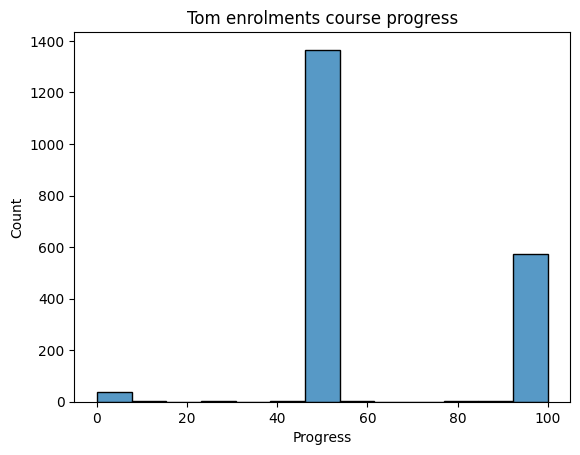

In [13]:
# Mapping course progress for the courses listed in the tom_enrolments database

sns.histplot(x=tom_enrolments_df["progress"])

plt.title("Tom enrolments course progress")
plt.xlabel("Progress")
plt.ylabel("Count")
plt.show()

In [149]:
# Filter the Tom emrolmets data so that we are only looking at completed courses:
completed_courses_df = tom_enrolments_df[tom_enrolments_df["progress"]==100]

# Group the completed courses by country:
completed_courses_by_country_df = completed_courses_df.groupby(["country", "course_category"])["id"].count()

In [150]:
completed_courses_by_country_df

country      course_category                             
Armenia      FMD Emergency Preparation Course                  4
             FMD Investigation Training Course               107
             FMD Laboratory Investigation Training Course      4
             Lumpy Skin Disease                               28
             Post Vaccination Monitoring                       8
             Risk Analysis along the Value Chain               4
             Safe Trade                                        4
Spain        African Swine Fever                               2
             Animal Depopulation                               1
             FMD Emergency Preparation Course                  2
             Lumpy Skin Disease                                4
             NU                                                1
             Open Access Courses                               1
             Simulation Exercises                              3
             Wildlife Surveillan

In [16]:
completed_courses_by_country_sum = completed_courses_by_country_df.groupby(["country"]).sum()

In [17]:
# How many courses have been completed by each country (cumulative)?
completed_courses_by_country_sum

country
Armenia        159
Spain           18
Switzerland    215
Tunisia        132
Turkey          48
Name: id, dtype: int64

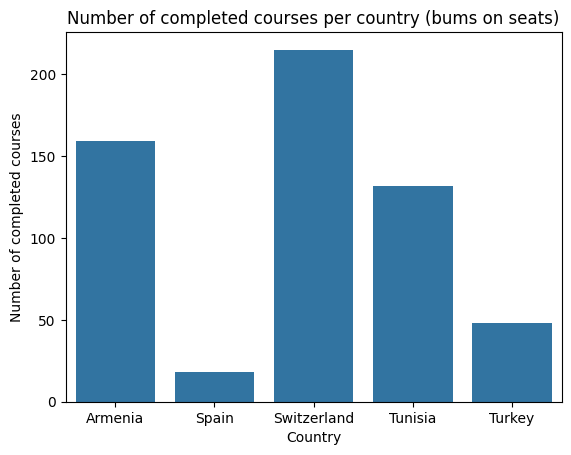

In [18]:
sns.barplot(data=completed_courses_by_country_sum)

plt.title("Number of completed courses per country (bums on seats)")
plt.xlabel("Country")
plt.ylabel("Number of completed courses")
plt.show()

In [39]:
brick_mapping_df = pd.read_excel("data/GET Prepared Training menu mapping_May2024.xlsx", skiprows=1)

In [43]:
brick_mapping_df.head()

,Course,Main topic,Level,Acccess,Disease covered,TOM Competency,Learning programs,Simulation exercises,Training,Laboratories,...,Restricted zones,Psychological support,Resource and impact tools and calculators,Logistic,National emergency anagement,Coordination and PPP,Wildlife,Recovery of disease status,Vaccination exit strategy,Re-stocking
0,Introduction to Foot-and-Mouth disease,FMD Introduction,Basic,Open,FMD,Tad 1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Introduction to Lumpy Skin disease,Lumpy Skin Disease introduction,Basic,Open,LSD,Tad 1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Introduction to Biorisk Minimum Standards,Biorisk introduction,Basic,Open,FMD,NaN,NaN,NaN,NaN,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Introduction to Animal Health surveillance,Passive surveillance introduction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Introduction to Simulation Exercises,Simulation introduction,Basic,Open,FAST,Tad 1,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
course_names = brick_mapping_df["Course"].tolist()
course_names

['Introduction to Foot-and-Mouth disease',
 'Introduction to Lumpy Skin disease',
 'Introduction to Biorisk Minimum Standards',
 'Introduction to Animal Health surveillance',
 'Introduction to Simulation Exercises',
 'FMD Emergency preparedness course',
 'LSD Emergency preparedness course',
 'RVF Emergency preparedness course',
 'SPGP Emergency preparedness course',
 'FMD investigation training course (for endemic countries)\xa0\xa0',
 'Passive surveillance. Online (multicountry) (English)',
 'Real-Time Training',
 'Support to\xa0\xa0 national simulation exercises. (Face-to-face drill or tabletop)',
 'Support to\xa0 multi-country simulation exercises',
 'Organizing Simulation Exercises for FAST disease emergencies  - Workshop (multicountry) (English)',
 'FAST disease crisis management: Dealing with the psychological aspects and the public perceptions  - Workshop (multicountry) (English)',
 'Putting vaccination into practice - Workshop (multicountry) (English)',
 'Wildlife surveillance 

TODO: Create a function that loops through the courses listed in the mapping file and creates a list of all the "brick" skills that are covered in the course as well as a list of diseases covered in the course. NOTE, if a course covers FAST diseases, this means that ALL diseases of interest are covered. FAST stands for "Foot and mouth and similar transboundary animal diseases"

In [45]:
# Within the brick_mapping dataframe convert NaN values to 0 and X to 1

brick_mapping_df.replace(to_replace='X', value=1, inplace=True)
brick_mapping_df["Disease covered"].fillna(value='', inplace=True)
brick_mapping_df.fillna(value=0, inplace=True)

In [46]:
brick_mapping_df.shape

(23, 39)

In [47]:
# Convert the brick mapping dataframe into a dict for easier handling:
temp_dict = brick_mapping_df.to_dict(orient='records')

In [48]:
temp_dict

[{'Course': 'Introduction to Foot-and-Mouth disease',
  'Main topic': 'FMD Introduction',
  'Level': 'Basic',
  'Acccess': 'Open ',
  'Disease covered': 'FMD',
  'TOM Competency': 'Tad 1',
  'Learning programs': 0.0,
  'Simulation exercises': 0.0,
  'Training': 0.0,
  'Laboratories': 0.0,
  'Contingency planning': 1,
  'Assessment': 0.0,
  'Identification, Registration and traceability': 0.0,
  'Risk assessment': 0.0,
  'Information data management': 0.0,
  'Models': 0.0,
  'Surveillance': 0.0,
  'Awareness': 1.0,
  'Clinical Examination': 'x',
  'Epidemiological Investigation': 'x',
  'Sampling': 'x',
  'Farm biosecurity': 'x',
  'Personal biosecurity': 'x',
  'Communication': 0.0,
  'Disposal': 0.0,
  'Humane killing of animals': 0.0,
  'Vaccination': 0.0,
  'Cleaning and disinfection': 0.0,
  'Movement control': 0.0,
  'Restricted zones': 0.0,
  'Psychological support': 0.0,
  'Resource and impact tools and calculators': 0.0,
  'Logistic': 0.0,
  'National emergency anagement': 0.0,

In [49]:
brick_mapping_dict = {}

for dict_item in temp_dict:
    brick_mapping_dict[dict_item["Course"]] = dict_item
    

In [50]:
brick_mapping_dict['Introduction to Biorisk Minimum Standards']

{'Course': 'Introduction to Biorisk Minimum Standards',
 'Main topic': 'Biorisk introduction',
 'Level': 'Basic',
 'Acccess': 'Open ',
 'Disease covered': 'FMD',
 'TOM Competency': 0,
 'Learning programs': 0.0,
 'Simulation exercises': 0.0,
 'Training': 0.0,
 'Laboratories': 1.0,
 'Contingency planning': 0,
 'Assessment': 0.0,
 'Identification, Registration and traceability': 0.0,
 'Risk assessment': 0.0,
 'Information data management': 0.0,
 'Models': 0.0,
 'Surveillance': 0.0,
 'Awareness': 0.0,
 'Clinical Examination': 0,
 'Epidemiological Investigation': 0,
 'Sampling': 0,
 'Farm biosecurity': 0,
 'Personal biosecurity': 0,
 'Communication': 0.0,
 'Disposal': 0.0,
 'Humane killing of animals': 0.0,
 'Vaccination': 0.0,
 'Cleaning and disinfection': 0.0,
 'Movement control': 0.0,
 'Restricted zones': 0.0,
 'Psychological support': 0.0,
 'Resource and impact tools and calculators': 0.0,
 'Logistic': 0.0,
 'National emergency anagement': 0.0,
 'Coordination and PPP': 0.0,
 'Wildlife':

In [51]:
i = brick_mapping_dict['Introduction to Biorisk Minimum Standards']
skills_covered_in_course = []

for item in i:
    if i[item] == 1:
        skills_covered_in_course.append(item)

i["skills_covered_in_course"] = skills_covered_in_course

In [52]:
skills_covered_in_course

['Laboratories']

In [53]:
brick_mapping_dict['Introduction to Biorisk Minimum Standards']

{'Course': 'Introduction to Biorisk Minimum Standards',
 'Main topic': 'Biorisk introduction',
 'Level': 'Basic',
 'Acccess': 'Open ',
 'Disease covered': 'FMD',
 'TOM Competency': 0,
 'Learning programs': 0.0,
 'Simulation exercises': 0.0,
 'Training': 0.0,
 'Laboratories': 1.0,
 'Contingency planning': 0,
 'Assessment': 0.0,
 'Identification, Registration and traceability': 0.0,
 'Risk assessment': 0.0,
 'Information data management': 0.0,
 'Models': 0.0,
 'Surveillance': 0.0,
 'Awareness': 0.0,
 'Clinical Examination': 0,
 'Epidemiological Investigation': 0,
 'Sampling': 0,
 'Farm biosecurity': 0,
 'Personal biosecurity': 0,
 'Communication': 0.0,
 'Disposal': 0.0,
 'Humane killing of animals': 0.0,
 'Vaccination': 0.0,
 'Cleaning and disinfection': 0.0,
 'Movement control': 0.0,
 'Restricted zones': 0.0,
 'Psychological support': 0.0,
 'Resource and impact tools and calculators': 0.0,
 'Logistic': 0.0,
 'National emergency anagement': 0.0,
 'Coordination and PPP': 0.0,
 'Wildlife':

In [54]:
def add_skills_covered_to_dict(i):
    skills_covered_in_course = []
    
    for key_value in i:
        if i[key_value] == 1:
            skills_covered_in_course.append(key_value)

    i["skills_covered_in_course"] = skills_covered_in_course

In [55]:
brick_mapping_dict['Introduction to Lumpy Skin disease']['Awareness']

1.0

In [56]:
add_skills_covered_to_dict(brick_mapping_dict['Introduction to Lumpy Skin disease'])

In [57]:
brick_mapping_dict['Introduction to Lumpy Skin disease']

{'Course': 'Introduction to Lumpy Skin disease',
 'Main topic': 'Lumpy Skin Disease introduction',
 'Level': 'Basic',
 'Acccess': 'Open ',
 'Disease covered': 'LSD',
 'TOM Competency': 'Tad 1',
 'Learning programs': 0.0,
 'Simulation exercises': 0.0,
 'Training': 0.0,
 'Laboratories': 0.0,
 'Contingency planning': 1,
 'Assessment': 0.0,
 'Identification, Registration and traceability': 0.0,
 'Risk assessment': 0.0,
 'Information data management': 0.0,
 'Models': 0.0,
 'Surveillance': 0.0,
 'Awareness': 1.0,
 'Clinical Examination': 'x',
 'Epidemiological Investigation': 'x',
 'Sampling': 0,
 'Farm biosecurity': 0,
 'Personal biosecurity': 0,
 'Communication': 0.0,
 'Disposal': 0.0,
 'Humane killing of animals': 0.0,
 'Vaccination': 0.0,
 'Cleaning and disinfection': 0.0,
 'Movement control': 0.0,
 'Restricted zones': 0.0,
 'Psychological support': 0.0,
 'Resource and impact tools and calculators': 0.0,
 'Logistic': 0.0,
 'National emergency anagement': 0.0,
 'Coordination and PPP': 0.0

In [58]:
for i in brick_mapping_dict:
    add_skills_covered_to_dict(brick_mapping_dict[i])

In [59]:
brick_mapping_dict

{'Introduction to Foot-and-Mouth disease': {'Course': 'Introduction to Foot-and-Mouth disease',
  'Main topic': 'FMD Introduction',
  'Level': 'Basic',
  'Acccess': 'Open ',
  'Disease covered': 'FMD',
  'TOM Competency': 'Tad 1',
  'Learning programs': 0.0,
  'Simulation exercises': 0.0,
  'Training': 0.0,
  'Laboratories': 0.0,
  'Contingency planning': 1,
  'Assessment': 0.0,
  'Identification, Registration and traceability': 0.0,
  'Risk assessment': 0.0,
  'Information data management': 0.0,
  'Models': 0.0,
  'Surveillance': 0.0,
  'Awareness': 1.0,
  'Clinical Examination': 'x',
  'Epidemiological Investigation': 'x',
  'Sampling': 'x',
  'Farm biosecurity': 'x',
  'Personal biosecurity': 'x',
  'Communication': 0.0,
  'Disposal': 0.0,
  'Humane killing of animals': 0.0,
  'Vaccination': 0.0,
  'Cleaning and disinfection': 0.0,
  'Movement control': 0.0,
  'Restricted zones': 0.0,
  'Psychological support': 0.0,
  'Resource and impact tools and calculators': 0.0,
  'Logistic': 0

Are all the courses that are in tom_enrolments covered in the GET Prepared Training Menu mapping excel sheet?

In [77]:
# Lets see what data is available in "course_fullname"
tom_enrolments_df["course_fullname"].value_counts()

course_fullname
Knowledge Bank                                                       424
Обучающий Онлайн Курс по Изучению Ящура на русском языке 4           102
Open Session Online 2014                                              94
About                                                                 79
Help                                                                  78
                                                                    ... 
FMD Emergency Preparation Course                                       1
FMD Emergency Preparation Course (En2)                                 1
FMD Emergency Preparation Course UK                                    1
Modelling Introductory Course: September 2015                          1
 Curso de Preparación para Alertas de Fiebre Aftosa en España (4)      1
Name: count, Length: 103, dtype: int64

In [76]:
# Lets see what courses are listed in the excel sheet:
general_course_names= brick_mapping_df["Course"].tolist()

In [72]:
# !pip install thefuzz
from thefuzz import fuzz, process

In [70]:
name = "FMD Emergency Preparation Course (En2)"
full_name = "FMD Emergency preparedness course"

print(f"Similarity score: {fuzz.partial_ratio(name, full_name)}")

Similarity score: 80


In [85]:
# Use fuzzy matching to match the tom_enrolments course name to the course name listed in the GET prepared mapping sheet:
predicted_course_name_fuzzy = process.extract("Open Session Online", general_course_names, scorer=fuzz.ratio)[0][0]
print("The predicted generic course title is: " + predicted_course_name_fuzzy)

The predicted generic course title is: Passive surveillance. Online (multicountry) (English)


In [92]:
def predict_course(tom_enrolements_course_fullname):
    return process.extract(tom_enrolements_course_fullname, general_course_names, scorer=fuzz.ratio)[0][0]

In [98]:
def return_fuzzy_score(tom_enrolements_course_fullname):
    return process.extract(tom_enrolements_course_fullname, general_course_names, scorer=fuzz.ratio)[0][1]

In [99]:
tom_enrolments_df["predicted_general_course_name"] = tom_enrolments_df["course_fullname"].apply(predict_course)
tom_enrolments_df["fuzzy_score"] = tom_enrolments_df["course_fullname"].apply(return_fuzzy_score)

In [105]:
tom_enrolments_df.sort_values(by=['fuzzy_score'], ascending=False)[["course_fullname", "predicted_general_course_name", "fuzzy_score"]]

,course_fullname,predicted_general_course_name,fuzzy_score
1658,Introduction to Foot-and-Mouth Disease,Introduction to Foot-and-Mouth disease,100
682,Introduction to Foot-and-Mouth Disease,Introduction to Foot-and-Mouth disease,100
1123,Introduction to Foot-and-Mouth Disease,Introduction to Foot-and-Mouth disease,100
513,Introduction to Foot-and-Mouth Disease,Introduction to Foot-and-Mouth disease,100
1489,Introduction to foot-and-mouth disease,Introduction to Foot-and-Mouth disease,100
...,...,...,...
1621,2 الدورة التدريبية للتحري عن مرض الحمى القلاعية,Passive surveillance. Online (multicountry) (E...,14
646,ما هو مسار المكافحة التدريجية لمرض الحمى القلا...,Passive surveillance. Online (multicountry) (E...,14
1119,2 الدورة التدريبية للتحري عن مرض الحمى القلاعية,Passive surveillance. Online (multicountry) (E...,14
450,Курс по Подготовке к Экстренной Ситуации по ящуру,Passive surveillance. Online (multicountry) (E...,14


In [113]:
tom_enrolments_df[["course_fullname", "predicted_general_course_name", "fuzzy_score"]][tom_enrolments_df["fuzzy_score"]< 67].sort_values(by=['fuzzy_score'], ascending=False)

,course_fullname,predicted_general_course_name,fuzzy_score
802,FMD Laboratory Investigation Training Course,FMD investigation training course (for endemic...,66
1280,FMD Laboratory Investigation Training Course,FMD investigation training course (for endemic...,66
458,FMD Laboratory Investigation Training Course,FMD investigation training course (for endemic...,66
548,Introduction to sheep pox and goat pox,Introduction to Foot-and-Mouth disease,66
756,FMD Laboratory Investigation Training Course,FMD investigation training course (for endemic...,66
...,...,...,...
1621,2 الدورة التدريبية للتحري عن مرض الحمى القلاعية,Passive surveillance. Online (multicountry) (E...,14
474,Учебный курс по Изучению Ящура на русском языке,Passive surveillance. Online (multicountry) (E...,14
473,Курс по Подготовке к Экстренной Ситуации по ящуру,Passive surveillance. Online (multicountry) (E...,14
450,Курс по Подготовке к Экстренной Ситуации по ящуру,Passive surveillance. Online (multicountry) (E...,14


In [118]:
course_names_with_low_fuzzy_score = tom_enrolments_df[tom_enrolments_df["fuzzy_score"]< 67].sort_values(by=['fuzzy_score'], ascending=False)["course_fullname"]

In [123]:
course_names_with_low_fuzzy_score.value_counts()

course_fullname
Knowledge Bank                                                                                                                                                       424
Обучающий Онлайн Курс по Изучению Ящура на русском языке 4                                                                                                           102
Open Session Online 2014                                                                                                                                              94
About                                                                                                                                                                 79
Help                                                                                                                                                                  78
                                                                                                                                           

In [122]:
course_names_with_low_fuzzy_score.value_counts().index.tolist()

['Knowledge Bank',
 'Обучающий Онлайн Курс по Изучению Ящура на русском языке 4',
 'Open Session Online 2014',
 'About',
 'Help',
 'Formation en ligne d’investigation sur la fièvre aphteuse pour la Tunisie',
 'Open Session Online 2016',
 'Introduction à la fièvre aphteuse',
 'Introduction to Rift Valley Fever',
 'African Swine Fever Preparedness Course for Europe ',
 'Учебный курс по Изучению Ящура на русском языке',
 'Vaccines, Vaccination and Post-Vaccination Monitoring 2023',
 'Подготовительный курс по борьбе с заразным узелковым дерматитом (ЗУД) на русском языке',
 'Foot-and-Mouth Disease Socio-economic Impact Assessment',
 'Applying Public-Private Partnerships to the Control of FMD and Similar Transboundary Diseases',
 'Post Vaccination Monitoring (PVM2)',
 'Formation en ligne d’investigations sur la fièvre aphteuse',
 'Réseau francophone pour le contrôle de la fièvre aphteuse',
 'Lumpy Skin Disease Preparedness Pilot Course',
 'Open Session Online 2018',
 "Preparation d'Urgence C

There are about 78 course names logged in the tom_enrolments table that are difficult to match to courses that exist in the GET Prepared training menu mapping excel sheet. 
- Some course names are not in english

For example 'دورة تدريبية للتحقق من وجود مرض الحمى القلاعية'

- some course names are too vague to be able to tell if it is the same as the generic course title.

For example should the course titled "FMD Laboratory Investigation Training Course" be tagged as "FMD investigation training course (for endemic countries)" OR "FMD Laboratory Training (English)"



In [124]:
course_names_with_high_fuzzy_score = tom_enrolments_df[tom_enrolments_df["fuzzy_score"]>= 67].sort_values(by=['fuzzy_score'], ascending=False)["course_fullname"]

In [132]:
print(course_names_with_low_fuzzy_score.shape)
print(course_names_with_high_fuzzy_score.shape)

(1630,)
(358,)


In [133]:
print(course_names_with_low_fuzzy_score.value_counts())
print(course_names_with_high_fuzzy_score.value_counts())

course_fullname
Knowledge Bank                                                                                                                                                       424
Обучающий Онлайн Курс по Изучению Ящура на русском языке 4                                                                                                           102
Open Session Online 2014                                                                                                                                              94
About                                                                                                                                                                 79
Help                                                                                                                                                                  78
                                                                                                                                           

In [139]:
tom_enrolments_df.head(20)

,id,full_name,email,course_fullname,course_shortname,course_category,city,country,institution,role,completed,time_enrolled,time_completed,progress,status,course_id,moodle_category,new_id,predicted_general_course_name,fuzzy_score
0,6379,Jon Simonyan,jsimmk19@mail.ru,Open Session Online 2014,Open Session Online 2014,NU,Erevan,Armenia,,,No,2020-07-10 00:00:00,None,50.0,Open,45.0,Resources / Open Session,179,Passive surveillance. Online (multicountry) (E...,39
1,6392,Mariam Militosyan,militosyan_96@mail.ru,Обучающий Онлайн Курс по Изучению Ящура на рус...,FITC_RU4,FMD Investigation Training Course,,Armenia,,,Yes,2020-09-17 00:00:00,2020-10-21 00:00:00,100.0,Completed,244.0,FMD Investigation Training Course,180,Passive surveillance - Workshop (multicountry)...,16
2,6393,Mariam Militosyan,militosyan_96@mail.ru,Knowledge Bank,Knowledge Bank,NU,,Armenia,,,No,2020-09-28 00:00:00,None,50.0,Open,3.0,Resources,181,Real-Time Training,31
3,6394,Irma Artushyan,irma.artushyan95@mail.ru,Обучающий Онлайн Курс по Изучению Ящура на рус...,FITC_RU4,FMD Investigation Training Course,,Armenia,,,Yes,2020-09-17 00:00:00,2020-10-21 00:00:00,100.0,Completed,244.0,FMD Investigation Training Course,183,Passive surveillance - Workshop (multicountry)...,16
4,6395,Irma Artushyan,irma.artushyan95@mail.ru,Open Session Online 2014,Open Session Online 2014,NU,,Armenia,,,No,2020-05-10 00:00:00,None,50.0,Open,45.0,Resources / Open Session,185,Passive surveillance. Online (multicountry) (E...,39
5,6441,Ilhan Genc,ilhan.genc@tarimorman.gov.tr,Altıncı Türkçe Çevrimiçi Şap Hastalığı Araştır...,FITC_TR6,FMD Investigation Training Course,ERZURUM,Armenia,,Central level government veterinarian,Yes,2022-11-14 00:00:00,2022-12-13 00:00:00,100.0,Completed,375.0,FMD Investigation Training Course,186,Introduction to Biorisk Minimum Standards,33
6,6442,Ilhan Genc,ilhan.genc@tarimorman.gov.tr,Knowledge Bank,Knowledge Bank,NU,ERZURUM,Armenia,,Central level government veterinarian,No,2022-11-25 00:00:00,None,50.0,Open,3.0,Resources,189,Real-Time Training,31
7,6459,Pascal Truong,pascal.truong@bluewin.ch,FMD Emergency Preparation Course (EN13),FEPC_EN13,FMD Emergency Preparation Course,,Switzerland,,Regional level/field veterinarian,Yes,2022-11-22 00:00:00,2022-12-26 00:00:00,100.0,Completed,374.0,FMD Emergency Preparation Course / English,190,FMD Emergency preparedness course,79
8,6460,Pascal Truong,pascal.truong@bluewin.ch,Knowledge Bank,Knowledge Bank,NU,,Switzerland,,Regional level/field veterinarian,No,2022-11-22 00:00:00,None,50.0,Open,3.0,Resources,191,Real-Time Training,31
9,6462,Jürg Frigg,j.frigg@laclinique.ch,FMD Emergency Preparation Course (EN13),FEPC_EN13,FMD Emergency Preparation Course,Madiswil,Switzerland,,Central level government veterinarian,Yes,2022-11-22 00:00:00,2022-12-22 00:00:00,100.0,Completed,374.0,FMD Emergency Preparation Course / English,192,FMD Emergency preparedness course,79


In [140]:
brick_mapping_df.columns

Index(['Course', 'Main topic', 'Level', 'Acccess', 'Disease covered',
       'TOM Competency', 'Learning programs', 'Simulation exercises',
       'Training', 'Laboratories', 'Contingency planning', 'Assessment',
       'Identification, Registration and traceability', 'Risk assessment',
       'Information data management', 'Models', 'Surveillance', 'Awareness',
       'Clinical Examination', 'Epidemiological Investigation', 'Sampling',
       'Farm biosecurity', 'Personal biosecurity', 'Communication', 'Disposal',
       'Humane killing of animals', 'Vaccination', 'Cleaning and disinfection',
       'Movement control', 'Restricted zones', 'Psychological support',
       'Resource and impact tools and calculators', 'Logistic',
       'National emergency anagement', 'Coordination and PPP', 'Wildlife',
       'Recovery of disease status', 'Vaccination exit strategy',
       'Re-stocking'],
      dtype='object')

In [141]:
brick_mapping_df.head()

,Course,Main topic,Level,Acccess,Disease covered,TOM Competency,Learning programs,Simulation exercises,Training,Laboratories,...,Restricted zones,Psychological support,Resource and impact tools and calculators,Logistic,National emergency anagement,Coordination and PPP,Wildlife,Recovery of disease status,Vaccination exit strategy,Re-stocking
0,Introduction to Foot-and-Mouth disease,FMD Introduction,Basic,Open,FMD,Tad 1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Introduction to Lumpy Skin disease,Lumpy Skin Disease introduction,Basic,Open,LSD,Tad 1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Introduction to Biorisk Minimum Standards,Biorisk introduction,Basic,Open,FMD,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Introduction to Animal Health surveillance,Passive surveillance introduction,0,0,,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Introduction to Simulation Exercises,Simulation introduction,Basic,Open,FAST,Tad 1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
brick_mapping_df

,Course,Main topic,Level,Acccess,Disease covered,TOM Competency,Learning programs,Simulation exercises,Training,Laboratories,...,Restricted zones,Psychological support,Resource and impact tools and calculators,Logistic,National emergency anagement,Coordination and PPP,Wildlife,Recovery of disease status,Vaccination exit strategy,Re-stocking
0,Introduction to Foot-and-Mouth disease,FMD Introduction,Basic,Open,FMD,Tad 1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Introduction to Lumpy Skin disease,Lumpy Skin Disease introduction,Basic,Open,LSD,Tad 1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Introduction to Biorisk Minimum Standards,Biorisk introduction,Basic,Open,FMD,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Introduction to Animal Health surveillance,Passive surveillance introduction,0,0,,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Introduction to Simulation Exercises,Simulation introduction,Basic,Open,FAST,Tad 1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FMD Emergency preparedness course,FMD Emergency Preparation Course,Intermediate,Nomination,Courses dedicated to one single disease among:...,Epi 3; Tad 3; Dis Prev 3; Bio 2; Sampling 3; A...,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,LSD Emergency preparedness course,Lumpy Skin Disease,Intermediate,Nomination,Courses dedicated to one single disease among:...,Epi 3; Tad 3; Dis Prev 3; Bio 2; Sampling 3; A...,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,RVF Emergency preparedness course,RVF intermediate,Intermediate,Nomination,Courses dedicated to one single disease among:...,Epi 3; Tad 3; Dis Prev 3; Bio 2; Sampling 3; A...,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,SPGP Emergency preparedness course,SPGP intermediate,Intermediate,Nomination,Courses dedicated to one single disease among:...,Epi 3; Tad 3; Dis Prev 3; Bio 2; Sampling 3; A...,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,FMD investigation training course (for endemic...,FMD Investigation Training Course,Intermediate,Nomination,Courses dedicated to one single disease among:...,Epi 3; Tad 3; Dis Prev 3; Bio 2; Sampling 3; A...,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
tom_enrolments_df["course_category"].value_counts()

course_category
NU                                              844
FMD Investigation Training Course               271
FMD Emergency Preparation Course                265
FMD Introduction                                 74
Socio-Economic Impact Assessment                 64
Post Vaccination Monitoring                      60
Progressive Control Pathway                      50
African Swine Fever                              49
Lumpy Skin Disease                               44
Rift Valley Fever Introduction                   35
Risk Analysis along the Value Chain              32
Simulation Exercises                             21
FMD Laboratory Investigation Training Course     20
Public-Private Partnerships                      20
Modelling                                        18
Lumpy Skin Disease Introduction                  17
NU                                               15
Psicological aspects and communication           13
Wildlife Surveillance                           

In [143]:
tom_enrolments_df.columns

Index(['id', 'full_name', 'email', 'course_fullname', 'course_shortname',
       'course_category', 'city', 'country', 'institution', 'role',
       'completed', 'time_enrolled', 'time_completed', 'progress', 'status',
       'course_id', 'moodle_category', 'new_id',
       'predicted_general_course_name', 'fuzzy_score'],
      dtype='object')

In [147]:
tom_enrolments_df["course_fullname"].shape

(1988,)

In [145]:
tom_enrolments_df["course_id"].value_counts()

course_id
3.0      419
244.0    102
45.0      91
46.0      77
14.0      76
        ... 
157.0      4
258.0      3
253.0      3
366.0      3
383.0      3
Name: count, Length: 80, dtype: int64